In [16]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse as sp
import cv2

Lecture de l'image 

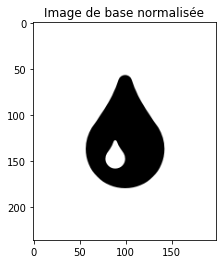

In [17]:
I = cv2.imread("im_goutte.png",0)
In = cv2.normalize(I,None,0,1.0,cv2.NORM_MINMAX,dtype=cv2.CV_32F)

plt.figure()
plt.title("Image de base normalisée")
plt.imshow(In,'gray') # affichage de l'image I en niveau de gris
plt.show()

Initialisation de notre snake 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


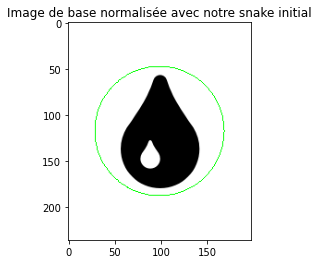

In [18]:
y,x = np.shape(I)
K = 400
cercle = np.zeros([2,K])
centreX = int(x/2)
centreY = int(y/2)
rayon = 70
theta = 0

c = list()
cc = np.zeros((K,1,2))

for i, angle in enumerate(np.linspace(0,2*np.pi,K)):
    cercle[0,i] = centreX + rayon*np.cos(angle)
    cercle[1,i] = centreY + rayon*np.sin(angle)
    

cc[:,0,0] = cercle[0,:]
cc[:,0,1] = cercle[1,:]
c.append(cc.astype(int))

IC = cv2.drawContours(image=cv2.cvtColor(In,cv2.COLOR_GRAY2BGR),contours=c,contourIdx=len(c) -1,color=(0,255,0),thickness=1,lineType=cv2.LINE_AA)

plt.figure()
plt.title("Image de base normalisée avec notre snake initial")
plt.imshow(IC,'gray') # affichage de l'image I en niveau de gris
plt.show()
    

Initialisation de l'algorithme

In [19]:
alpha = 5
beta = 3
gamma = 5
deltaT = 0.1

#Opérateur différentiel
D2 =sp.diags([1,-2,1],[-1,0,1],shape=(K,K)).toarray()
D2[0,K-1] = 1
D2[K-1,0] = 1
D4 =sp.diags([1,-4,6,-4,1],[-2,-1,0,1,2],shape=(K,K)).toarray()
D4[1,K-1] = 1
D4[K-1,1] = 1
D4[0,K-2] = 1
D4[K-2,0] = 1
D4[0,K-1] = -4
D4[K-1,0] = -4

D = alpha*D2 - beta*D4
A = np.linalg.inv(np.eye(K,K)-deltaT*D)

#Gradient
gy, gx = np.gradient(In)
gradI = gx**2+gy**2
gradY,gradX = np.gradient(gradI)

#Condition d'arrêt : lorsque norm(xn+1-xn)<epsilon on va prendre pr tester en premier epison = 10**-3

Implémentation de la procédure itérative

In [20]:
epsilon = 10**-3

xn2 = cc
xn1 = cc

n = 1
while n>epsilon :
    xn1 = xn2
    xn2[:,0,0] = A*(xn1[:,0,0]+deltaT*gamma*gradX)
    n=0

ValueError: operands could not be broadcast together with shapes (400,) (236,198) 